<a href="https://colab.research.google.com/github/HamsikaAS/DEL_LAB_1BM22AI052/blob/main/del_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adversarially Trained Model with Tangent Prop Accuracy: (accuracy_tangent_prop * 100:.2f)%
Tangent Classifier Accuracy: 77.50%
Adversarially Trained Model with Tangent Prop Accuracy: 72.50%


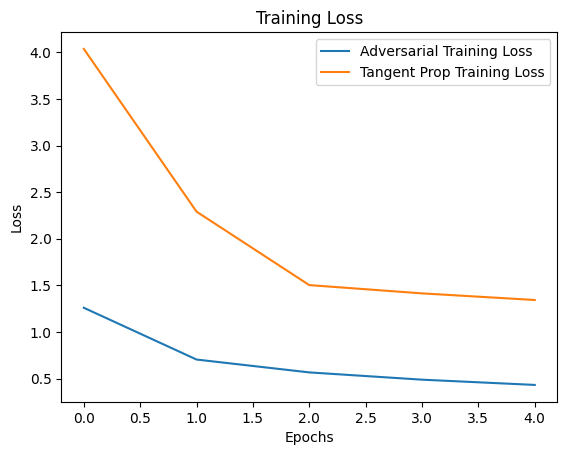

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
subset_size = 1000
x_train = x_train[:subset_size] / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200] / 255.0
y_test = y_test[:200]


def create_model():
  model = Sequential([
  Flatten(input_shape=(28, 28)),Dense(64, activation='relu'),Dense(10, activation='softmax')
  ])
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model


def generate_adversarial_examples(model,x,y,epsilon=0.1):
  np.random.seed(100)
  perturbations = np.sign(np.random.randn(*x.shape))
  x_adv = x + epsilon * perturbations
  return np.clip(x_adv, 0, 1)

class TangentProp(Layer):
  def call(self, x):
    perturbation = tf.random.normal(shape=tf.shape(x), stddev=0.1)
    return x + perturbation

def tangent_distance(x1, x2):
  return np.linalg.norm(x1 - x2)

model = create_model()
x_adv = generate_adversarial_examples(model, x_train, y_train)
x_combined = np.concatenate([x_train, x_adv])
y_combined = np.concatenate([y_train, y_train])
history_adv = model.fit(x_combined, y_combined, epochs=5, validation_data=(x_test, y_test), verbose=0)

model_tangent_prop = create_model()
model_tangent_prop.add(TangentProp())
history_tangent_prop = model_tangent_prop.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test),verbose=0)
loss, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f'Adversarially Trained Model with Tangent Prop Accuracy: (accuracy_tangent_prop * 100:.2f)%')

def classify_with_tangent_distance(x_train, y_train, x_test):
  x_train_flat = x_train.reshape(x_train.shape[0], -1)
  x_test_flat = x_test.reshape(x_test.shape[0], -1)
  y_pred = []
  for x in x_test_flat:
    distances = [tangent_distance(x, x_train_flat[i]) for i in range(len(x_train_flat))]
    nearest_index = np.argmin(distances)
    y_pred.append(y_train[nearest_index])
  return np.array(y_pred)

y_pred = classify_with_tangent_distance(x_train, y_train, x_test)
accuracy_tangent_classifier = np.mean(y_pred == y_test)
print(f'Tangent Classifier Accuracy: {accuracy_tangent_classifier * 100:.2f}%')

loss, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f'Adversarially Trained Model with Tangent Prop Accuracy: {accuracy_tangent_prop *100:.2f}%')

plt.plot(history_adv.history['loss'], label='Adversarial Training Loss')
plt.plot(history_tangent_prop.history['loss'], label='Tangent Prop Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()